<a href="https://colab.research.google.com/github/rosshalpin/clip-guided-scene-arrangement/blob/main/DissertationProject_v0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'

!ln -s /content/drive/My\ Drive/Colab\ Notebooks/ $nb_path

sys.path.insert(0,nb_path)

!ln -s /content/gdrive/My\ Drive/ /mydrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link '/content/notebooks/Colab Notebooks': File exists
ln: failed to create symbolic link '/mydrive': File exists


In [2]:
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    import torch
    if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install --target=$nb_path fvcore iopath
        !pip install --target=$nb_path --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install --target=$nb_path 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [3]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2022-08-06 16:04:57--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.2’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0s      

2022-08-06 16:04:57 (5.77 MB/s) - ‘plot_image_grid.py.2’ saved [1608/1608]



In [4]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.ops import sample_points_from_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, join_meshes_as_batch, join_meshes_as_scene, Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights,
    AmbientLights,
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np

In [5]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = '/content/drive/My Drive/DissertationProject_v0.0/data'

In [6]:
device

device(type='cuda', index=0)

In [7]:
def load_mesh(input_path) -> Meshes:
  obj_filename = os.path.join(DATA_DIR, input_path)
  return load_objs_as_meshes([obj_filename], device=device)

In [8]:
fruit_mesh = load_mesh(f"{DATA_DIR}/fruit_mesh/pear_export.obj")
table_mesh = load_mesh(f"{DATA_DIR}/table_mesh/GenericClassicTable001.obj")

In [9]:
# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1,
    bin_size=None
)

# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(8, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -15.0]])


# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

In [10]:
import numpy as np


def render(batch_size, camera_dist, mesh):
  num_cameras = int(batch_size/3)
  meshes = mesh.extend(batch_size)

  azim = np.linspace(-180, 180, num_cameras, endpoint=False)
  elev_a = np.linspace(45, 45, num_cameras, endpoint=False)
  elev_b = np.linspace(-45, -45, num_cameras, endpoint=False)
  elev_c = np.linspace(0, 0, num_cameras, endpoint=False)

  lights = AmbientLights(device=device)

  Ra, Ta = look_at_view_transform(dist=camera_dist, azim=azim, elev=elev_a)
  Rb, Tb = look_at_view_transform(dist=camera_dist, azim=azim, elev=elev_b)
  Rc, Tc = look_at_view_transform(dist=camera_dist, azim=azim, elev=elev_c)

  R = np.concatenate((Ra, Rb, Rc), axis=0)
  T = np.concatenate((Ta, Tb, Tc), axis=0)

  cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

  images = renderer(meshes, cameras=cameras, lights=lights).cpu().numpy()

  return images, num_cameras

In [11]:
# table_offset = table_mesh.verts_padded().new_tensor([0, 0, -1]).expand(table_mesh.verts_packed().shape)
# fruit_offset = fruit_mesh.verts_padded().new_tensor([0, 0, 0]).expand(fruit_mesh.verts_packed().shape)
# double_mesh = join_meshes_as_scene([fruit_mesh.clone().scale_verts(0.1).offset_verts_(fruit_offset), table_mesh.clone().scale_verts(3.5).offset_verts_(table_offset)])

In [12]:
# plot_batch_individually(fruit_mesh)

In [13]:
# images, num_cameras = render(18,6, double_mesh)
# image_grid(images, rows=3, cols=num_cameras, rgb=True)

In [14]:
try:
  import clip
except ModuleNotFoundError:
  !pip install git+https://github.com/openai/CLIP.git
  import clip

In [15]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

In [17]:
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [18]:
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [19]:
def get_similarity(images: list, description: str):
  text_tokens = clip.tokenize([description]).cuda()
  images = map(preprocess, images)
  image_input =  torch.tensor(np.stack(images)).cuda()
  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

  return similarity[0]

In [20]:
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

In [21]:
def get_pil_image(input):
  return Image.fromarray((input * 255).astype('uint8'))

In [22]:
# image = get_pil_image(images[12, ..., :3])
# result = get_similarity([image], "a fruit place under a table")

In [23]:
# result

In [24]:
try:
  import tensorforce
except ModuleNotFoundError:
  !pip install git+https://github.com/tensorforce/tensorforce.git
  import tensorforce

In [25]:
class SceneObject():
    def __init__(self, mesh, scale=1):
      new_mesh = mesh.clone().scale_verts(scale)
      self._mesh = new_mesh
      self._scale = scale
      self._position = self._mesh_position()

    @property
    def mesh(self):
      return self._mesh

    @property
    def position(self):
      return self._position

    @position.setter
    def position(self, value):
      offset = [round(a-b,3) for a, b in zip(value, self._position)]
      self._set_position_helper(offset)

    def _mesh_position(self):
      return [round(float(((c.cpu()[0]+c.cpu()[1])/2)), 3) for c in self._mesh.get_bounding_boxes()[0]]

    def _set_position_helper(self, value):
      offset = self._mesh.verts_padded().new_tensor(value).expand(self._mesh.verts_packed().shape)
      self._mesh = self._mesh.offset_verts(offset)
      self._position = self._mesh_position()

    def translate(self, value):
      self._set_position_helper(value)


In [33]:
fruit_object = SceneObject(fruit_mesh, scale=0.04)
fruit_object.position=[0,0,0]

table_object = SceneObject(table_mesh)
table_object.position=[0,0,0]

In [34]:
double_mesh = join_meshes_as_scene([table_mesh, fruit_object.mesh])

In [35]:
plot_batch_individually(double_mesh)

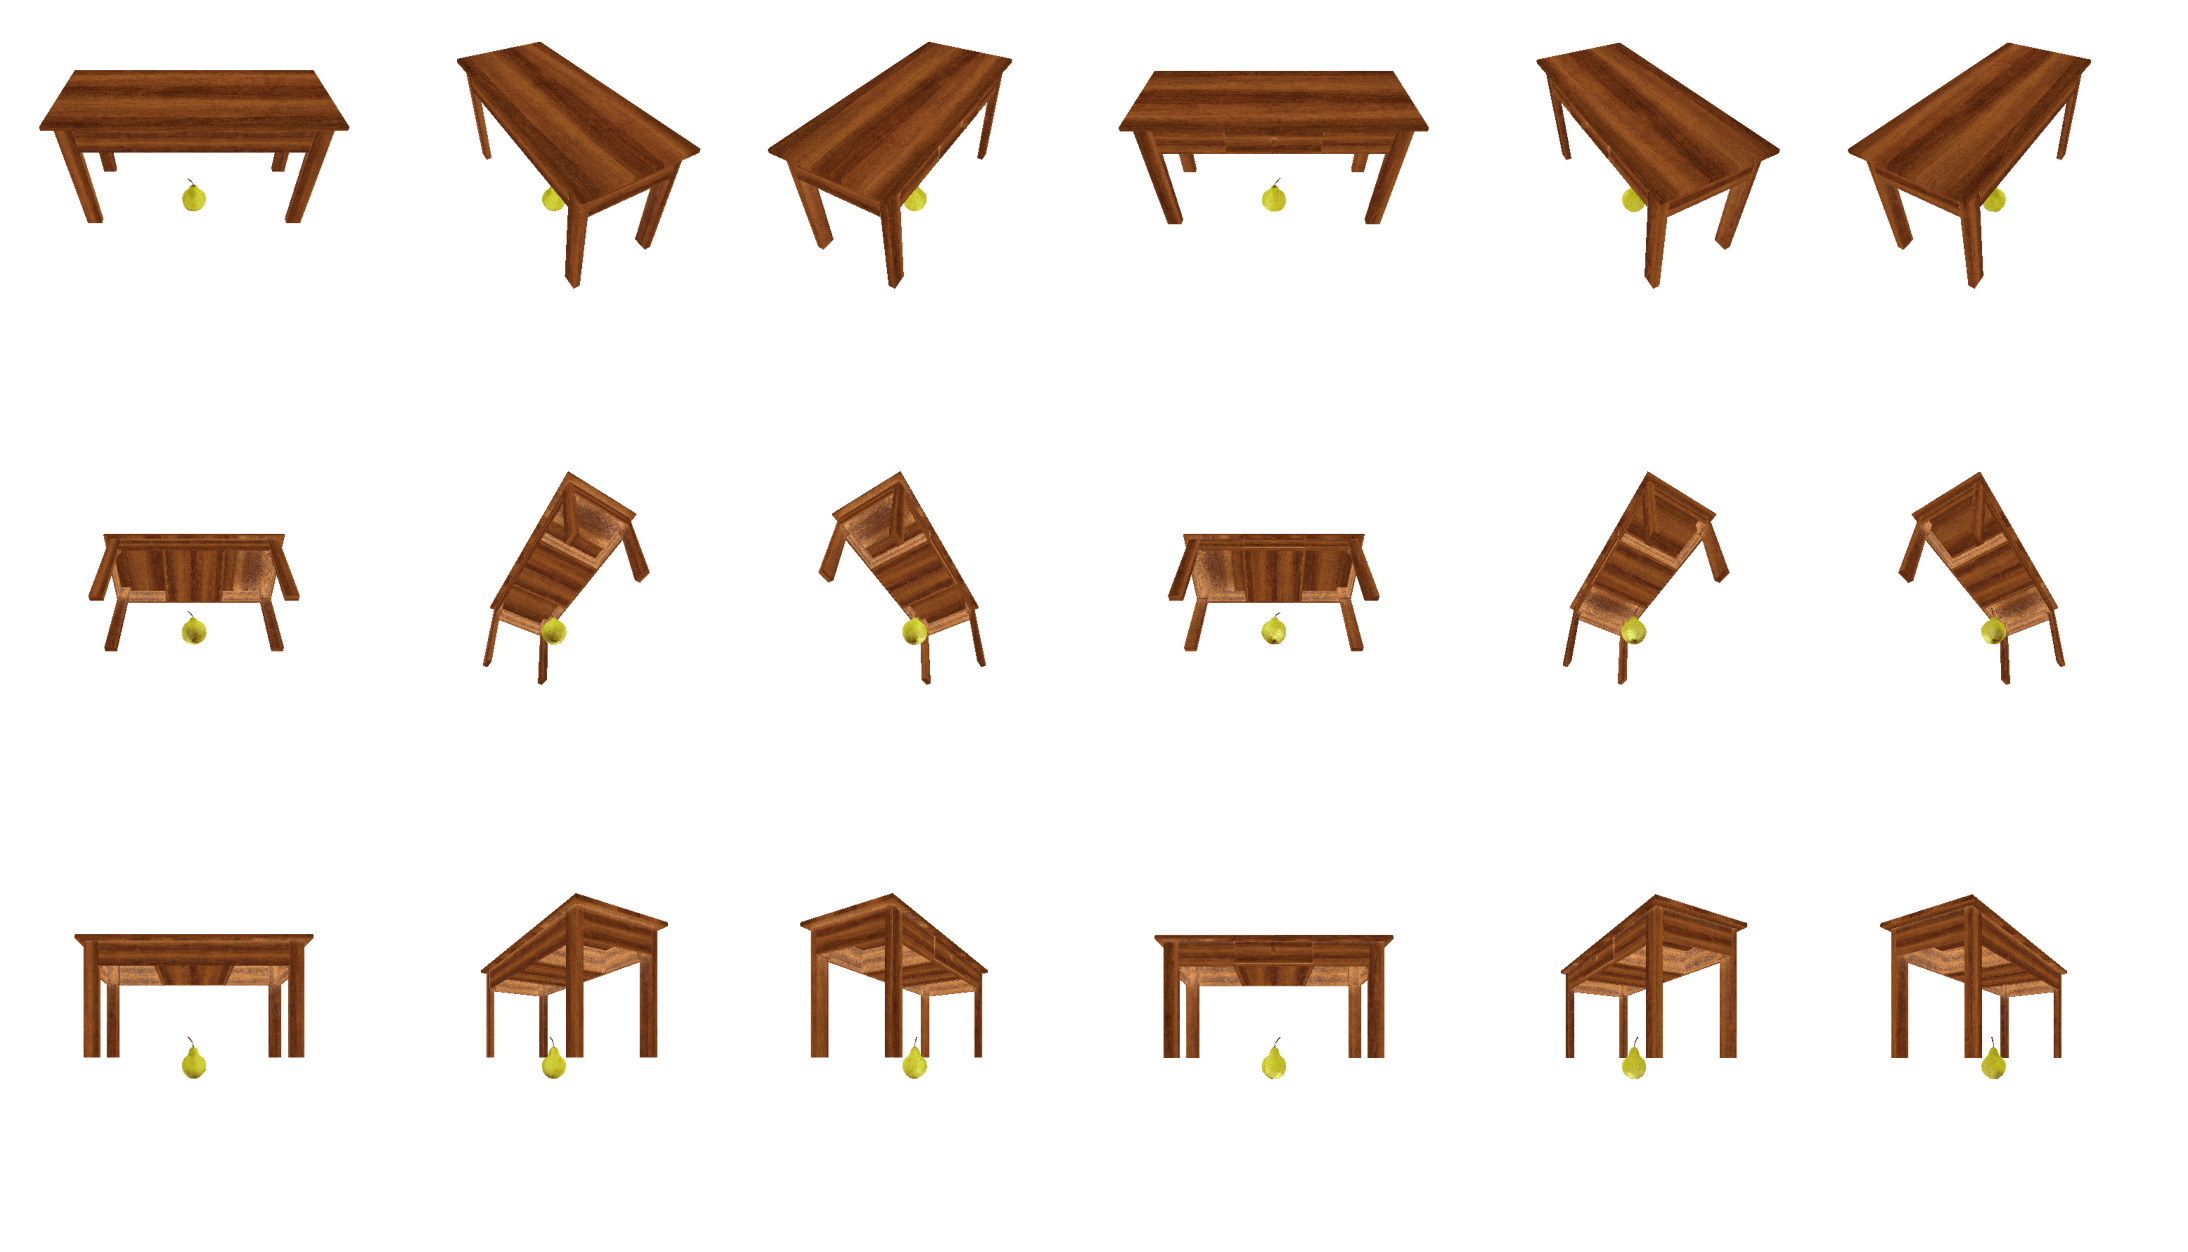

In [36]:
images, num_cameras = render(18,1.7, double_mesh)
image_grid(images, rows=3, cols=num_cameras, rgb=True)

In [30]:
from tensorforce.environments import Environment


class CustomEnvironment(Environment):

    def __init__(self):
        super().__init__()

    def states(self):
        return dict(type='float', shape=(8,))

    def actions(self):
        return dict(type='int', num_values=4)

    # Optional: should only be defined if environment has a natural fixed
    # maximum episode length; restrict training timesteps via
    #     Environment.create(..., max_episode_timesteps=???)
    def max_episode_timesteps(self):
        return 100

    # Optional additional steps to close environment
    def close(self):
        super().close()

    def reset(self):
        state = np.random.random(size=(8,))
        return state

    def execute(self, actions):
        next_state = np.random.random(size=(8,))
        terminal = np.random.random() < 0.5
        reward = np.random.random()
        return next_state, terminal, reward

In [31]:
positive_directions = [
    [0.1,0,0], # +X
    [0,0.1,0], # +Y
    [0,0,0.1] # +Z
]

all_directions = [
    *positive_directions,
    *list(map(lambda x: [a * -1 for a in x], positive_directions))
]

def offset_action(input_mesh, direction):
 offset = input_mesh.verts_padded().new_tensor(direction).expand(input_mesh.verts_packed().shape)
 input_mesh.clone().offset_verts_(offset)